# Deep SITH Exploration

## Breakdown 

@deep_isith.py: Python script that is called to actually create an instance of the network. Deep SITH inherits SITH features, so non-optional SITH parameters need to be included as well, or previously designated. 

    A Module built for SITH like an LSTM

    Parameters
    ----------
    layer_params: list
        A list of dictionaries for each layer in the desired DeepSITH. All
        of the parameters needed for the SITH part of the Layers, as well as
        a hidden_size and optional act_func are required to be present.

    layer_params keys
    -----------------
    hidden_size: int (default in_features)
        The size of the output of the hidden layer. Please note that the
        in_features parameter for the next layer's SITH representation should be
        equal to the previous layer's hidden_size. This parameter will default
        to the in_features of the current SITH layer if not specified.
    act_func: torch.nn.Module (default None)
        The torch layer of the desired activation function, or None if no
        there is no desired activation function between layers.

    In addition to these keys, you must include all of the non-optional SITH
    layer keys in each dictionary. Please see the SITH docstring for
    suggestions. 

### Set-up

In [3]:
!python /Users/arshiyaansari/Documents/masters/capstone/SITH_Layer/setup.py install

running install
running bdist_egg
running egg_info
writing SITH_Layer.egg-info/PKG-INFO
writing dependency_links to SITH_Layer.egg-info/dependency_links.txt
writing top-level names to SITH_Layer.egg-info/top_level.txt
reading manifest file 'SITH_Layer.egg-info/SOURCES.txt'
writing manifest file 'SITH_Layer.egg-info/SOURCES.txt'
installing library code to build/bdist.macosx-10.9-x86_64/egg
running install_lib

creating build/bdist.macosx-10.9-x86_64/egg
creating build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
copying SITH_Layer.egg-info/PKG-INFO -> build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
copying SITH_Layer.egg-info/SOURCES.txt -> build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
copying SITH_Layer.egg-info/dependency_links.txt -> build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
copying SITH_Layer.egg-info/top_level.txt -> build/bdist.macosx-10.9-x86_64/egg/EGG-INFO
zip_safe flag not set; analyzing archive contents...
creating 'dist/SITH_Layer-0.0.0-py3.8.egg' and adding 'build/bdist.macosx-10.9-x8

In [4]:
%matplotlib inline

In [5]:
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from math import factorial
import random
import torch.nn.functional as F
import numpy as np
import seaborn as sn
import pandas as pd
import os
import sys
from os.path import join
import glob
from math import factorial
ttype = torch.cuda.DoubleTensor if torch.cuda.is_available() else torch.DoubleTensor
print(ttype)
sys.path.append('/Users/arshiyaansari/Documents/masters/capstone/SITH_Layer')
from sith import DeepSITH
from tqdm.notebook import tqdm
import pickle
sn.set_context("poster")
print("Finished importing packages and modules!")

<class 'torch.DoubleTensor'>
Finished importing packages and modules!


### Code from Yibo's Preprocssing and iSITH 

TODO: We want to make sure that all the code can communicate with one another. We should attempt to modularize code so that we can call code that Yibo wrote in a file that I'm working on, etc. 

In [6]:
import mne
import numpy as np
import pandas as pd
from mne.io import RawArray
from mne.channels import make_standard_montage
from mne.epochs import concatenate_epochs
from mne import create_info, find_events, Epochs, concatenate_raws, pick_types
from mne.decoding import CSP
def creat_mne_raw_object(fname,read_events=True):
    """
    obtained from @author: alexandrebarachant
    https://www.kaggle.com/alexandrebarachant/beat-the-benchmark-0-67
    Create a mne raw instance from csv file.
    Make sure the events and data files are in the same folder
    data are transformed into microvolts
    """
    # Read EEG file
    data = pd.read_csv(fname)
    
    # get chanel names
    ch_names = list(data.columns[1:])
    
    # read EEG standard montage from mne
    #montage = make_standard_montage('standard_1005')

    ch_type = ['eeg']*len(ch_names)
    data = 1e-6*np.array(data[ch_names]).T
    
    if read_events:
        # events file
        ev_fname = fname.replace('_data','_events')
        # read event file
        events = pd.read_csv(ev_fname)
        events_names = events.columns[1:]
        events_data = np.array(events[events_names]).T
        # define channel type, the first is EEG, the last 6 are stimulations
        ch_type.extend(['stim']*6)
        ch_names.extend(events_names)
        # concatenate event file and data
        data = np.concatenate((data,events_data))
        
    # create and populate MNE info structure
    info = create_info(ch_names,sfreq=500.0, ch_types=ch_type)
    #info['filename'] = fname
    print(info)
    # create raw object 
    raw = RawArray(data,info,verbose=False)
    #print(data)
    return raw

In [7]:
# Loading in training data 
raw = creat_mne_raw_object("/Users/arshiyaansari/Documents/masters/capstone/SIF_Capstone/train/subj1_series1_data.csv")

<Info | 7 non-empty values
 bads: []
 ch_names: Fp1, Fp2, F7, F3, Fz, F4, F8, FC5, FC1, FC2, FC6, T7, C3, Cz, ...
 chs: 32 EEG, 6 STIM
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 38
 projs: []
 sfreq: 500.0 Hz
>


### Preliminary Plotting

34 events found
Event IDs: [1]


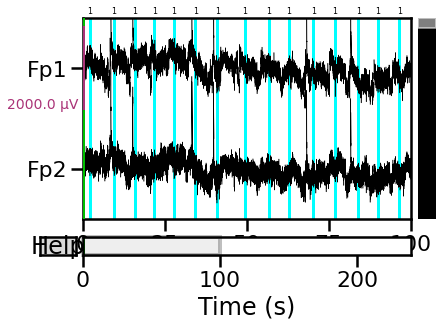

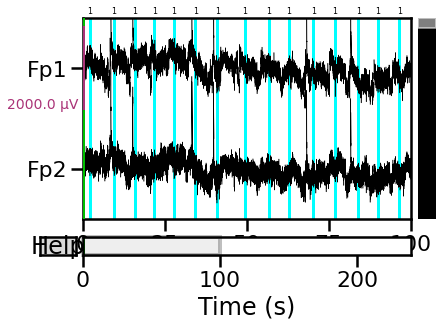

In [11]:
# Scaling is necessary to show the graphs properly
# Vertical lines indicate a event
scalings = {'eeg': 10e-4}
events = mne.find_events(raw, stim_channel=['HandStart',])
raw.plot(n_channels=2,scalings=scalings,duration=100.0, events= events)